# An analysis of tracks played by the Legacy Music Hour

The Legacy Music Hour is a podcast devoted to tracks from the 8-bit and 16-bit videogame consoles.  It is hosted by two comedians, Rob F. Switch and Brent Weinbach, who show sincere enthusiasm for the music. In the course of listening to it over the years, I've developed a lot of affection for the show.  The podcast has over 150 episodes, showcasing well over 2000 tracks.  

Before every episode, the hosts upload its full track listing, with game, system, and composer information.  I decided to write some code to pull all this information into a data frame and do some analysis to see what this track data says.

## Downloading and cleaning the tracks

This section details how I downloaded the data and checked for errors in the records.  Feel free to skip to the analysis section for the more interesting.  I leave this as a record of the trouble one usually has to go to in getting the right data!

### Pulling the track data

First, we will pull all of the track data from the LMH Blogger website.

In [5]:
import re
def lmh_standardize_whitespace(text):
    """ 
    There is some nonuniformity in the episode descriptions of line breaks.
    some this routine standardizes the line breaks to simply be newlines
    while this breaks the html for display, it helps with parsing.
    """
    # first replace <br />\n -> <br />
    text = re.sub('<br\s*?/>\n', '<br />', text)
    # then replace <br /> -> \n
    return re.sub('<br\s*?/>', '\n', text)


In [8]:
import datetime
def blogger_url_gen(baseurl,start_date,end_date):
    """
    Given a start and end datetime, generate a blogger page query.
    """
    if not end_date:
        end_date = datetime.datetime.now()
    start_str = start_date.strftime("%Y-%M-%d")
    end_str = end_date.strftime("%Y-%M-%d")
    return baseurl+'/search?updated-min='+start_str+'T00:00:00-08:00&updated-max='+end_str+'T00:00:00-08:00'

def lmh_url_gen(start_date,end_date=None):
    return blogger_url_gen('http://legacymusichour.blogspot.ca/',start_date,end_date)

In [56]:
from bs4 import BeautifulSoup
import urllib2
import json
import contextlib

def normalize_track(episode_number,track_fields):
    """
    Given a track which has (potentially) many composers, 
    generate a data point per composer.
    """
    for composer in track_fields[1].split(','):
        yield {'episode_number':episode_number,
               'game':track_fields[0],
               'composer':re.sub('\(.*\)','',composer).strip(), # remove parenthetical notes
               'title':track_fields[2],
               'producer':track_fields[3],
               'console':track_fields[4],
               'year':track_fields[5]}

def parse_tracks(soup):
    """
    Parse the soup of an LMH blogger page, pulling out the tracks
    """
    for outer_p in soup.find_all("div",class_="post-outer"):
        title_text = outer_p.find("h3",class_="post-title entry-title")
        if title_text != None and "Episode" in title_text.text:
            episode_number = ''.join([c 
                                      for c in title_text.text.strip().split(':')[0] 
                                      if c.isdigit()])
            title_text.text.strip()
            rawlist = [
                i.strip().split(' - ') 
                for i in outer_p.text.strip().split('\n\n') 
                if ' - ' in i and len(i.split(' - '))>=6]
            if len(rawlist) > 0:
                for j in rawlist:
                    if j[1] != 'Composer':
                        for track in normalize_track(episode_number,
                                                     [str(f) for f in j]):
                            yield track

def compoyors():
    """
    Generator for all the tracks on LMH
    """    
    data_url = lmh_url_gen(datetime.datetime(year=2011,month=1,day=1))
    has_older_posts = True
    while has_older_posts:
        with contextlib.closing(urllib2.urlopen(data_url)) as response:        
            html = response.read().decode('utf-8')
            soup = BeautifulSoup(lmh_standardize_whitespace(html))
            for track in parse_tracks(soup):
                yield track                
            older_posts = soup.find("a",text="Older Posts")
            if older_posts:
                has_older_posts = True
                data_url = soup.find("a",text="Older Posts").get('href')
            else:
                has_older_posts = False

In [106]:
import pandas as pd
tracks_df = pd.DataFrame([track for track in compoyors()])

### Cleaning the data

The above script pulls the data with some errors and lack of standardization. We need clean up the entries.

In [49]:
# first let's look at the episode numbers to see if there are any missing episodes
stored_episodes = set([int(enum) for enum in tracks_df['episode_number']])
print "Missing episodes:", stored_episodes.symmetric_difference(range(1,(max(stored_episodes)+1)))

Missing episodes: set([11])


Missing episode 11?  Which one was that?  Ah, the Lost Level!  Let's leave that one out for now.

What about other fields?  Any bad composer names that aren't right?  First let's check for some obvious problems, like names with too many fields.

In [130]:
sorted(set([composer for composer in tracks_df['composer'] if len(composer.split(' '))>3]))

[u'Act 4-2 Metal Version',
 u'Blades of Steel intro',
 u'Falcom Sound Team J.D.K.',
 u'Final Fantasy V Main Theme',
 u'Mecano Associates (Fumihito Kasatani',
 u'Shinji Hosoe  (comp.',
 u'Tim and Geoff Follin',
 u'Yasuhisa Watanabe Naoto Yagishita',
 u'and Doug Grigsby III']

Ok, some of those are ok, but 'Blades of Steel intro' is not.  What's up with that track?

In [142]:
from IPython.display import HTML
pd.set_option('display.notebook_repr_html', True)
HTML(tracks_df[tracks_df['composer']=='Blades of Steel intro'].to_html())

,composer,console,episode_number,game,producer,title,year
3073,Blades of Steel intro,none,35,Playing With Power!,"Shinya Sakamoto, Kazuki Muraoka, Atsushi Fujio...",Blades of Steel,none


Episode 35.  The Covers episode.  Looks like most of these got messed up:

In [136]:
tracks_df[tracks_df['episode_number']=='35']

,composer,console,episode_number,game,producer,title,year
3069,Song,Album/Context,35,Artist,Composer,Game,Label
3070,Troian Beauty,Final Fantasy IV: Piano Collections,35,"Toshiyuki Mori, Shirou Satou (arr.)",Nobuo Uematsu,Final Fantasy IV,Square Brand
3071,Last Wave,live video recording,35,S.S.T. Band,Hiroshi Kawaguchi,Out Run,none
3072,Jungle,demo CD,35,The Advantage,Kazuki Muraoka,Metal Gear,none
3073,Blades of Steel intro,none,35,Playing With Power!,"Shinya Sakamoto, Kazuki Muraoka, Atsushi Fujio...",Blades of Steel,none
3074,Final Fantasy V Main Theme,Orchestral Game Concert 2/Game Music Concert 2...,35,"Tokyo Memorial Orchestra, Katsuhisa Hattori (a...",Nobuo Uematsu,Final Fantasy V,Warner Music Japan
3075,Area 5,live on The Legacy Music Hour Episode 35,35,"Brent Weinbach (arr., per.)",Naoki Kodaka,Blaster Master,none
3076,Marble Zone,live on The Legacy Music Hour Episode 35,35,"Brent Weinbach (arr., per.)",Masato Nakamura,Sonic the Hedgehog,none
3077,Main Theme,Sega Piano Nocturne,35,Kiminori Atsuta (arr.),Tokuhiko Uwabo,Space Harrier,Wave Master
3078,Rainbow Road,Super Mario Kart Album,35,The OneUps,Soyo Oka,Super Mario Kart,OneUp Studios


Let's just remove this episode from the results.

In [147]:
clean_tracks_df = tracks_df[tracks_df['episode_number']!='35']

Episode 35 is gone.  Now let's look at years for any non-numeric results in the year field.

In [148]:
for i in sorted(set([year.lower() for year in clean_tracks_df['year']])):
    try:
        x = int(re.sub('\s\(.*\)','',i)) # accepts years and years + (unreleased)
    except:
        print 'Error at', i

Error at genesis
Error at hisayoshi ogura
Error at mega drive
Error at nes
Error at super famicom
Error at unknown


A mix of different errors here.  Let's go through them one by one.  First, the 'genesis' year.

In [153]:
HTML(clean_tracks_df[clean_tracks_df['year'].str.lower()=='genesis'].to_html())

,composer,console,episode_number,game,producer,title,year
140,Ludwig van Beethoven,Shiny Entertainment,160,Earthworm Jim 2,3rd Movement),"See Jim Run, Run Jim Run (Moonlight Sonata",Genesis
141,Tommy Tallarico,Shiny Entertainment,160,Earthworm Jim 2,3rd Movement),"See Jim Run, Run Jim Run (Moonlight Sonata",Genesis


None of the other tracks from 160 are messed up.  Let's just fix this one in place.  The error came from the '-' after the '(Moonlight Sonata', which I was using as a delimiter.

In [157]:
clean_tracks_df.ix[clean_tracks_df.year.str.lower()=='genesis','console']='Genesis'
clean_tracks_df.ix[clean_tracks_df.year.str.lower()=='genesis','producer']='Shiny'
clean_tracks_df.ix[clean_tracks_df.year.str.lower()=='genesis','year']='1996'

Next, we want to handle the unclean entry where year is 'hisayoshi ogura'.

In [159]:
HTML(clean_tracks_df[clean_tracks_df['year'].str.lower()=='hisayoshi ogura'].to_html())

,composer,console,episode_number,game,producer,title,year
3919,Hajime Hirasawa,SNES -1993\nDarius Plus,6,Star Fox,Nintendo,Main Theme (End Credits),Hisayoshi Ogura


Oh yeah, look at that, this one is all messed up.  What happened?  Looks like I munged two improperly formatted entries together, one for StarFox and one for Darius Plus.  We'll have to manually fix it.  First we'll remove the entry and add two new entries.

In [166]:
clean_tracks_df = clean_tracks_df[clean_tracks_df['year'].str.lower()!='hisayoshi ogura']
starfox_entry = {'composer': u'Hajime Hirasawa',
  'console': u'SNES',
  'episode_number': u'6',
  'game': u'Star Fox',
  'producer': u'Nintendo',
  'title': u'Main Theme (End Credits)',
  'year': u'1993'}
dariusplus_entry = {'composer': u'Hisayoshi Ogura',
  'console': u'PC Engine',
  'episode_number': u'6',
  'game': u'Darius Plus',
  'producer': u'Taito',
  'title': u'Enter Your Initials',
  'year': u'1990'}
clean_tracks_df = pd.concat([clean_tracks_df,pd.DataFrame([starfox_entry,dariusplus_entry])])
HTML(clean_tracks_df.tail().to_html())

,composer,console,episode_number,game,producer,title,year
4040,Kazunaka Yamane,NES,1,Double Dragon,Tradewest,Title Screen,1988
4041,Naoki Kadoka,NES,1,Blaster Master,Sunsoft,Area 1,1988
4042,Tsukasa Masuko,NES,1,T & C Surf Designs: Wood & Water Rage,LJN,Level Music,1988
0,Hajime Hirasawa,SNES,6,Star Fox,Nintendo,Main Theme (End Credits),1993
1,Hisayoshi Ogura,PC Engine,6,Darius Plus,Taito,Enter Your Initials,1990


In [170]:
clean_tracks_df = clean_tracks_df.reset_index(drop=True)
HTML(clean_tracks_df.tail().to_html())

,composer,console,episode_number,game,producer,title,year
4025,Kazunaka Yamane,NES,1,Double Dragon,Tradewest,Title Screen,1988
4026,Naoki Kadoka,NES,1,Blaster Master,Sunsoft,Area 1,1988
4027,Tsukasa Masuko,NES,1,T & C Surf Designs: Wood & Water Rage,LJN,Level Music,1988
4028,Hajime Hirasawa,SNES,6,Star Fox,Nintendo,Main Theme (End Credits),1993
4029,Hisayoshi Ogura,PC Engine,6,Darius Plus,Taito,Enter Your Initials,1990


In [173]:
HTML(clean_tracks_df[clean_tracks_df['year'].str.lower()=='mega drive'].to_html())

,composer,console,episode_number,game,producer,title,year
2939,Tsuyoshi Matsushima,Compile,40,Madou Monogatari I,Dark Noble's Theme),Opening (Part 2,Mega Drive
2940,Polygon Junkie,Compile,40,Madou Monogatari I,Dark Noble's Theme),Opening (Part 2,Mega Drive


In [188]:
clean_tracks_df = clean_tracks_df[clean_tracks_df['year'].str.lower()!='mega drive']
madou_1 = {'composer': u'Tsuyoshi Matsushima',
  'console': u'Mega Drive',
  'episode_number': u'40',
  'game': u'Madou Monogatari I',
  'producer': u'Compile',
  'title': u'Opening (Part 2 Dark Noble\'s Theme)',
  'year': u'1996'}
madou_2 = {'composer': u'Polygon Junkie',
  'console': u'Mega Drive',
  'episode_number': u'40',
  'game': u'Madou Monogatari I',
  'producer': u'Compile',
  'title': u'Opening (Part 2 Dark Noble\'s Theme)',
  'year': u'1996'}
clean_tracks_df = pd.concat([clean_tracks_df,pd.DataFrame([madou_1,madou_2])])
HTML(clean_tracks_df.tail().to_html())

,composer,console,episode_number,game,producer,title,year
4027,Tsukasa Masuko,NES,1,T & C Surf Designs: Wood & Water Rage,LJN,Level Music,1988
4028,Hajime Hirasawa,SNES,6,Star Fox,Nintendo,Main Theme (End Credits),1993
4029,Hisayoshi Ogura,PC Engine,6,Darius Plus,Taito,Enter Your Initials,1990
0,Tsuyoshi Matsushima,Mega Drive,40,Madou Monogatari I,Compile,Opening (Part 2 Dark Noble's Theme),1996
1,Polygon Junkie,Mega Drive,40,Madou Monogatari I,Compile,Opening (Part 2 Dark Noble's Theme),1996


In [180]:
HTML(clean_tracks_df[clean_tracks_df['year'].str.lower()=='nes'].to_html())

,composer,console,episode_number,game,producer,title,year
160,Cyndi Lauper,Konami,160,The Goonies II,Basement,Good Enough/Main Theme (The Goonies 'R' Good E...,NES
161,Stephen Broughton Lunt,Konami,160,The Goonies II,Basement,Good Enough/Main Theme (The Goonies 'R' Good E...,NES
162,Arthur Stead,Konami,160,The Goonies II,Basement,Good Enough/Main Theme (The Goonies 'R' Good E...,NES
163,Satoe Terashima,Konami,160,The Goonies II,Basement,Good Enough/Main Theme (The Goonies 'R' Good E...,NES


In [199]:
clean_tracks_df = clean_tracks_df[clean_tracks_df['year'].str.lower()!='nes']
goonies_tracks = [{'composer': u'Cyndi Lauper',
                    'console': u'NES',
                    'episode_number': u'160',
                    'game': u'The Goonies II',
                    'producer': u'Konami',
                    'title': u'Good Enough/Main Theme (The Goonies \'R\' Good Enough)',
                    'year': u'1987'},
                  {'composer': u'Stephen Broughton Lunt',
                    'console': u'NES',
                    'episode_number': u'160',
                    'game': u'The Goonies II',
                    'producer': u'Konami',
                    'title': u'Good Enough/Main Theme (The Goonies \'R\' Good Enough)',
                    'year': u'1987'},
                  {'composer': u'Arthur Stead',
                    'console': u'NES',
                    'episode_number': u'160',
                    'game': u'The Goonies II',
                    'producer': u'Konami',
                    'title': u'Good Enough/Main Theme (The Goonies \'R\' Good Enough)',
                    'year': u'1987'},
                  {'composer': u'Satoe Terashima',
                    'console': u'NES',
                    'episode_number': u'160',
                    'game': u'The Goonies II',
                    'producer': u'Konami',
                    'title': u'Good Enough/Main Theme (The Goonies \'R\' Good Enough)',
                    'year': u'1987'}]
clean_tracks_df = pd.concat([clean_tracks_df,pd.DataFrame(goonies_tracks)])
HTML(clean_tracks_df.tail().to_html())

In [190]:
HTML(clean_tracks_df[clean_tracks_df['year'].str.lower()=='super famicom'].to_html())

,composer,console,episode_number,game,producer,title,year
98,Yoko Kanno,Koei,162,Nobunaga no Yabou: Haouden,Daimyos' Theme),Usual Theme (Blue Whitecaps,Super Famicom


In [192]:
clean_tracks_df = clean_tracks_df[clean_tracks_df['year'].str.lower()!='super famicom']
koei_tracks = [{'composer': u'Yoko Kanno',
                    'console': u'Super Famicom',
                    'episode_number': u'162',
                    'game': u'Nobunaga no Yabou: Haouden',
                    'producer': u'Koei',
                    'title': u'Usual Theme (Blue Whitecaps - Daimyo\'s Theme)',
                    'year': u'1993'}]
clean_tracks_df = pd.concat([clean_tracks_df,pd.DataFrame(koei_tracks)])
HTML(clean_tracks_df.tail().to_html())

,composer,console,episode_number,game,producer,title,year
0,Cyndi Lauper,NES,160,The Goonies II,Konami,Good Enough/Main Theme (The Goonies 'R' Good E...,1987
1,Stephen Broughton Lunt,NES,160,The Goonies II,Konami,Good Enough/Main Theme (The Goonies 'R' Good E...,1987
2,Arthur Stead,NES,160,The Goonies II,Konami,Good Enough/Main Theme (The Goonies 'R' Good E...,1987
3,Satoe Terashima,NES,160,The Goonies II,Konami,Good Enough/Main Theme (The Goonies 'R' Good E...,1987
0,Yoko Kanno,Super Famicom,162,Nobunaga no Yabou: Haouden,Koei,Usual Theme (Blue Whitecaps - Daimyo's Theme),1993


In [175]:
HTML(clean_tracks_df[clean_tracks_df['year'].str.lower()=='unknown'].to_html())

,composer,console,episode_number,game,producer,title,year
2484,unknown,Mega Drive (China),61,Lion King II,unknown,Qin's Tomb,unknown


In this case, the year is actually unknown. 

In [203]:
clean_tracks_df = clean_tracks_df.reset_index(drop=True)

Now what about the cleanliness of the consoles?  There seems to be a wide variety here.

In [193]:
set(clean_tracks_df.console.str.lower())

{u'arcade',
 u'arcade (japan)',
 u'atari 2600',
 u'atari jaguar',
 u'dreamcast',
 u'dreamcast (japan)',
 u'famicom',
 u'famicom disk system',
 u'game boy',
 u'game boy (europe)',
 u'game boy (japan)',
 u'game gear',
 u'game gear (europe)',
 u'game gear (japan)',
 u'gamecube',
 u'genesis',
 u'konami',
 u'lynx',
 u'mega drive',
 u'mega drive (australia)',
 u'mega drive (china)',
 u'mega drive (europe)',
 u'mega drive (sega net work system)',
 u'mega drive (taiwan)',
 u'mega drive meganet',
 u'n64',
 u'neo geo',
 u'neo geo (japan)',
 u'nes',
 u'nes (europe)',
 u'nintendo ds',
 u'panasonic 3do',
 u'pc engine',
 u'playstation',
 u'ps2',
 u'sega 32x',
 u'sega cd',
 u'sega mark iii',
 u'sega master system',
 u'sega master system (europe)',
 u'snes',
 u'snes (europe)',
 u'super famicom',
 u'super famicom satellaview',
 u'super famicom/sufami turbo',
 u'super nintendo',
 u'supergrafx',
 u'turbografix-16',
 u'turbografx-16',
 u'turbografx-cd',
 u'wii',
 u'wiiware',
 u'xbox 360 (japan)'}

Let's start by removing the differentiation between countries.  Let's also differentiate between the japanese and american names of consoles, defaulting to the japanese names.  We'll do this with the following function.

In [194]:
console_map = {u'arcade':'arcade',
             u'arcade (japan)':'arcade',
             u'atari 2600':'atari 2600',
             u'atari jaguar':'atari jaguar',
             u'dreamcast':'dreamcast',
             u'dreamcast (japan)':'dreamcast',
             u'famicom':'famicom',
             u'famicom disk system':'famicom',
             u'game boy':'game boy',
             u'game boy (europe)':'game boy',
             u'game boy (japan)':'game boy',
             u'game gear':'game gear',
             u'game gear (europe)':'game gear',
             u'game gear (japan)':'game gear',
             u'gamecube':'gamecube',
             u'genesis':'mega drive',
             u'lynx':'lynx',
             u'mega drive':'mega drive',
             u'mega drive (australia)':'mega drive',
             u'mega drive (china)':'mega drive',
             u'mega drive (europe)':'mega drive',
             u'mega drive (sega net work system)':'mega drive',
             u'mega drive (taiwan)':'mega drive',
             u'mega drive meganet':'mega drive',
             u'n64':'n64',
             u'neo geo':'neo geo',
             u'neo geo (japan)':'neo geo',
             u'nes':'famicom',
             u'nes (europe)':'famicom',
             u'nintendo ds':'nintendo ds',
             u'panasonic 3do':'3do',
             u'pc engine':'pc engine',
             u'playstation':'playstation',
             u'ps2':'playstation 2',
             u'sega 32x':'sega 32x',
             u'sega cd':'sega cd',
             u'sega mark iii':'mark iii',
             u'sega master system':'master system',
             u'sega master system (europe)':'master system',
             u'snes':'super famicom',
             u'snes (europe)':'super famicom',
             u'super famicom':'super famicom',
             u'super famicom satellaview':'super famicom',
             u'super famicom/sufami turbo':'super famicom',
             u'super nintendo':'super famicom',
             u'supergrafx':'supergrafx',
             u'turbografix-16':'pc engine',
             u'turbografx-16':'pc engine',
             u'turbografx-cd':'pc engine cd',
             u'wii':'wii',
             u'wiiware':'wii',
             u'xbox 360 (japan)':'xbox 360'}

In [206]:
clean_tracks_df['console'] = clean_tracks_df['console'].map(lambda x: console_map[x.lower()])

In [207]:
set(clean_tracks_df.console.str.lower())

{'3do',
 'arcade',
 'atari 2600',
 'atari jaguar',
 'dreamcast',
 'famicom',
 'game boy',
 'game gear',
 'gamecube',
 'lynx',
 'mark iii',
 'master system',
 'mega drive',
 'n64',
 'neo geo',
 'nintendo ds',
 'pc engine',
 'pc engine cd',
 'playstation',
 'playstation 2',
 'sega 32x',
 'sega cd',
 'super famicom',
 'supergrafx',
 'wii',
 'xbox 360'}

## Some Descriptive Statistics

Now that we have cleaned the track data, we can start to take a look at what is in there.

### Totals

In [369]:
import numpy as np
just_tracks = (clean_tracks_df[['episode_number','console','game','title','year']]
               .drop_duplicates()
               .sort(columns='game'))
print 'Total tracks:', len(just_tracks)

Total tracks: 2606


In [341]:
just_tracks['episode_number'] = just_tracks['episode_number'].apply(int)

In [350]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

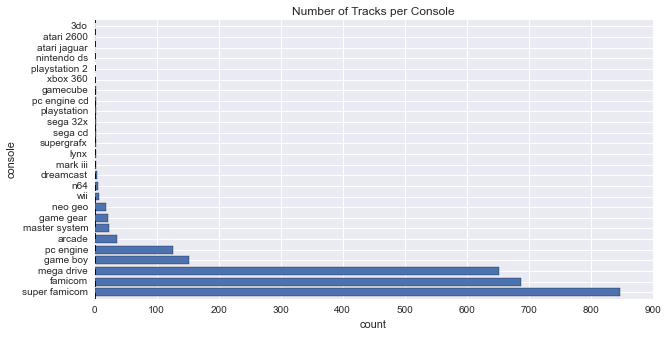

In [370]:
(just_tracks.groupby('console')
 .count()['game']
 .order(ascending=False)
 .plot(kind='barh',figsize=(10,5)));
plt.xlabel('count');
plt.title('Number of Tracks per Console');

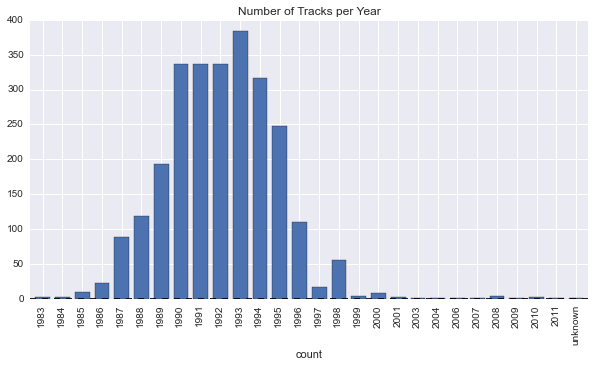

In [374]:
#just_tracks['year']=just_tracks.year.apply(lambda x: x.split(' ')[0])
(just_tracks.groupby('year')
 .count()['game']
 #.order(ascending=False)
 .plot(kind='bar',figsize=(10,5)));
plt.xlabel('count');
plt.title('Number of Tracks per Year');

In [380]:
console_remap = {'3do':'other',
                 'arcade':'other',
                 'atari 2600':'other',
                 'atari jaguar':'other',
                 'dreamcast':'other',
                 'famicom':'famicom',
                 'game boy':'game boy',
                 'game gear':'other',
                 'gamecube':'other',
                 'lynx':'other',
                 'mark iii':'other',
                 'master system':'other',
                 'mega drive':'mega drive',
                 'n64':'other',
                 'neo geo':'other',
                 'nintendo ds':'other',
                 'pc engine':'pc engine',
                 'pc engine cd':'pc engine',
                 'playstation':'other',
                 'playstation 2':'other',
                 'sega 32x':'other',
                 'sega cd':'other',
                 'super famicom':'super famicom',
                 'supergrafx':'other',
                 'wii':'other',
                 'xbox 360':'other'};
just_tracks['simpleconsole'] = just_tracks.console.apply(lambda x: console_remap[x]);
just_tracks['episode_number'] = just_tracks['episode_number'].apply(int);

2533     58
3898      6
1030    119
2399     64
3370     25
196     158
2059     78
2800     45
2885     42
3038     37
2922     41
1298    108
569     139
2113     76
416     146
...
219     155
1274    109
2162     73
3531     20
798     129
796     129
546     140
1914     85
2128     75
2039     79
1972     83
2411     64
2129     75
3076     34
3603     17
Name: episode_number, Length: 2606, dtype: object

In [381]:
epVSconsole = pd.pivot_table(just_tracks,
                             values=['title'],
                             rows=['episode_number'],
                             cols=['simpleconsole'],
                             aggfunc='count', 
                             fill_value=0)['title'].sort()

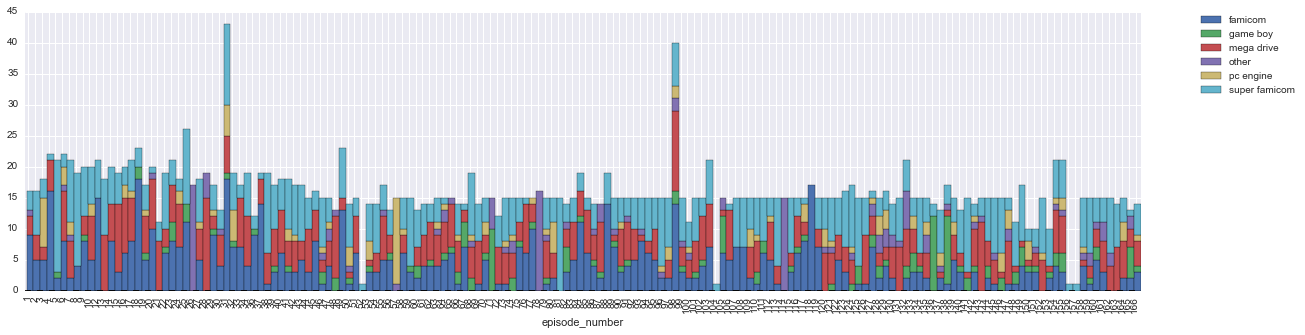

In [384]:
ax = epVSconsole.plot(kind='bar',stacked=True,figsize=(20,5));
for container in ax.containers:
    plt.setp(container,width=1);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

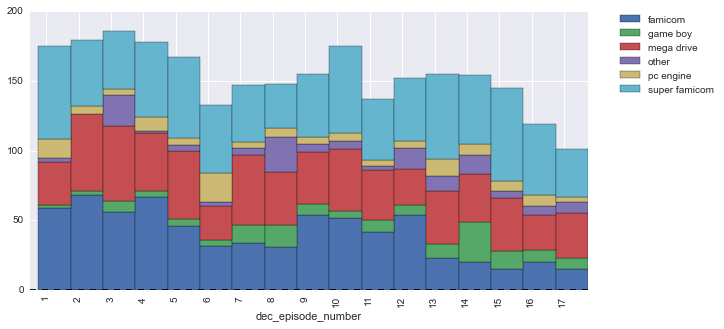

In [391]:
just_tracks['dec_episode_number'] = just_tracks['episode_number'].apply(lambda x: x/10+1);
decepVSconsole = pd.pivot_table(just_tracks,
                                values=['title'],
                                rows=['dec_episode_number'],
                                cols=['simpleconsole'],
                                aggfunc='count',
                                fill_value=0)['title'].sort(ascending=True)
ax = decepVSconsole.plot(kind='bar',stacked=True,figsize=(10,5));
for container in ax.containers:
    plt.setp(container,width=1);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);